# Supervised Learning

In this lab, you will build a simple text classifier to predict whether a movie review has positive or negative sentiment. You will learn to use a count-based bag-of-words model and logistic regression from `sklearn` library to do this.
We will use [IMDB movie review dataset](https://ai.stanford.edu/~amaas/data/sentiment/).

# Download data
First, let's download the data. Run the following commands to download and unzip the data.



In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz

--2022-02-03 16:20:46--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  23.5MB/s    in 4.0s    

2022-02-03 16:20:51 (19.8 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



The downloaded IMDB dataset should now be under `/content/` folder.

In [ ]:
!ls /content/aclImdb/

imdbEr.txt  imdb.vocab	README	test  train


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

## Preprocess and load the data

Here, we will load the data and preprocess it. We will extract features from our data and transform the features into vector (or matrix) form.

In [ ]:
def preprocess_text(text):
    """
    Function that preprocesses the string
    """
    preprocessed_text = text.lower().replace("<br />", "")
    return preprocessed_text
        
    
def read_file(file_name, label):
    """
    Function that reads a file 
    and return the raw text, preprocessed text, and label
    """
    with open(file_name, "r") as f:
        raw_text = f.read()
        preprocessed_text = preprocess_text(raw_text)
    return raw_text, preprocessed_text, label

def construct_dataset(dataset_dir):
    """
    Function that loads a dataset
    @param offset: skip first offset items in this dir
    """
    pos_dir = os.path.join(dataset_dir, "pos")
    neg_dir = os.path.join(dataset_dir, "neg")
    dir_list = [neg_dir, pos_dir]
    raw_contents, contents, labels = [], [], []
    all_pos = os.listdir(pos_dir)
    all_neg = os.listdir(neg_dir)
    data_size = len(all_neg)
    for i in range(data_size):
        for lbl, dataset in enumerate([all_neg, all_pos]):
          raw_content, content, label = read_file(os.path.join(dir_list[lbl], dataset[i]), lbl)
          contents.append(content)
          raw_contents.append(raw_content)
          labels.append(label)

    return raw_contents, contents, labels

In [ ]:
path = "/content/aclImdb/"
train_dir = os.path.join(path, "train")
test_dir = os.path.join(path, "test")
sentiments = ["Negative", "Positive"]

The dataset is already split into training and test set.
However, we should not touch the test data during initial model hyperparameter tuning and model selection stage. 
Let's split the given train data into training set and validation set.

In [ ]:
import numpy as np

In [ ]:
test_raw_contents, test_contents, test_labels = construct_dataset(test_dir)
raw_contents, contents, labels = construct_dataset(train_dir)

# TODO: split data from train_dir into train, and validation set
# ADD CODE HERE
from sklearn.model_selection import train_test_split
train_contents, val_contents, train_labels, val_labels =  train_test_split(contents, labels, random_state=42)

print(f"Train size: {len(train_contents)}, "
      f"\nVal size: {len(val_contents)}, "
      f"\nTest size: {len(test_contents)}")

Train size: 18750, 
Val size: 6250, 
Test size: 25000


In [ ]:
print("Review: ", train_contents[0])
print("Sentiment: ", sentiments[train_labels[0]])

Review:  i saw this film on its release, and have watched it 3 or 4 more times, including last week. i regret i have to be a voice of dissension with regard to mr. branagh's performance.this is really a glorious, sumptuous film, to say nothing of ambitious at over 4 hours long - beautifully shot and designed. derek jacobi, julie christie, kate winslet, richard briers, and many others do fine jobs. then there's kenneth branagh. if ever there was a vanity project for an actor, this is it, and mr. branagh spares nothing in putting the "ham" in hamlet. from the stunt casting (which gives us the worst performance ever by the woefully miscast jack lemmon), to the bits of distracting business thrown in to infuse a sense of "naturalness," to his own performance which runs the gamut from throwing away the single most famous soliloquy in all of literature to screaming every line of others. his performance confirms that, while he may come across better on stage where bigger is necessary, he has n

# Bag of words
Our training data is in text format, but for feeding it as input to a machine learning model, we need to transform the text into numbers.

To do this is to represent each example in the data as a vector of word counts.

For example:  
X = ['NLP is fun', 'NYU is fun'] 

features = ['NLP', 'is', 'fun', 'NYU']  

Vectorized_X:  
[ [1 1 1 0]   
  [0 1 1 1 ]  ]



Using `sklearn.feature_extraction.text.CountVectorizer`, we will construct a `CountVectorizer` class that extract features from training data using the most frequent words in the training data.

We will then transform the text data into BoW vector representations using the `transform` function of the `CountVectorizer` --- each row of the input matrix (vector) corresponds to an example in the dataset, each column corresponds to a word, and each entry corresponds to the number of times that word appears in the corresponding example.


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# TODO: YOUR CODE HERE
vectorizer = CountVectorizer(max_features=2000)
vectorizer.fit(train_contents)
X_train = vectorizer.transform(train_contents)
X_val = vectorizer.transform(val_contents)
X_test = vectorizer.transform(test_contents)

y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)




In [ ]:
vocab = vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train

<18750x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 1927059 stored elements in Compressed Sparse Row format>

# Logistic Regression

Now, we will train a logistic regression classifier on our data. 


In [ ]:
from sklearn.linear_model import LogisticRegression

# Define Logistic Regression model
# TODO: YOUR CODE HERE
model = LogisticRegression()

# Fit the model to training data
# TODO: YOUR CODE HERE
model.fit(X_train, y_train)

# make prediction using the trained model
# TODO: YOUR CODE HERE
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Report the accuracy of the model on training and validation set.  
Hint: `sklearn.metrics.accuracy_score`

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
# TODO: YOUR CODE HERE
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("Training accuracy:", train_accuracy)
print("Validation accuracy:", val_accuracy) 

Training accuracy: 0.91632
Validation accuracy: 0.856


Let's check prediction of the model on a random example in validation set.

In [ ]:
import random
j = random.randint(0,len(y_val))
print("True label: ", sentiments[y_val[j]])
print("Prediction: " , sentiments[y_val_pred[j]])
print(val_contents[j].strip())

True label:  Negative
Prediction:  Negative
this is just a terrible 'comedy' -- it really is a bad film. there are no funny elements. no jokes that are funny. i don't know how some people can claim this dismal short film could be 'smartest' or 'quality.' perhaps if its the only film that a person has seen you can make that claim of the brothers. but, i have seen thousands of better films: namely leonard part six (now, that's funny)! i don't know how the brothers is even considered eligible to be listed on the internet movie database: its more like a home video than an actual film.jokes aside, just skip this film. a root canal is more enjoyable that this cliche-ridden unfunny material.


Finally, we can check the coefficients, or learned weights, of each word feature to understand which features are generally associated with positive or negative sentiment.

In [ ]:
coefficients = model.coef_[0]
indices = np.argsort(coefficients) 
# Most negatively weighted
print("Words associated with negative sentiment")
for i in indices[:10]:
  print(vocab[i], coefficients[i])
print()
# Most positively weighted
print("Words associated with positive sentiment")
for i in indices[-10:]: 
  print(vocab[i], coefficients[i])

Words associated with negative sentiment
waste -2.300525430128202
disappointment -2.029574145919604
poorly -1.7908461513112346
disappointing -1.5910704044002728
worst -1.588947008136935
awful -1.5600929079799712
dull -1.479276015332105
badly -1.3469795078322326
lacks -1.3368690929166624
pointless -1.3349946234472732

Words associated with positive sentiment
rare 0.9645343087530625
excellent 0.980946948082533
gem 0.9952991886301369
enjoyable 0.9992675540059773
funniest 1.0032344878519697
perfect 1.0533786558481362
incredible 1.0669070958357159
surprisingly 1.134024554517445
superb 1.284814827525812
wonderfully 1.375441517625772


In [ ]:
from wordcloud import WordCloud

positive_word_score_dict = {}
negative_word_score_dict = {}

for i in indices:
    positive_word_score_dict[vocab[i]] = coefficients[i]
    negative_word_score_dict[vocab[i]] = -coefficients[i]

positive_wordcloud = WordCloud(width=500,height=500,scale=10,background_color=None,mode='RGBA').generate_from_frequencies(positive_word_score_dict)
negative_wordcloud = WordCloud(width=500,height=500,scale=10,background_color=None,mode='RGBA').generate_from_frequencies(negative_word_score_dict)

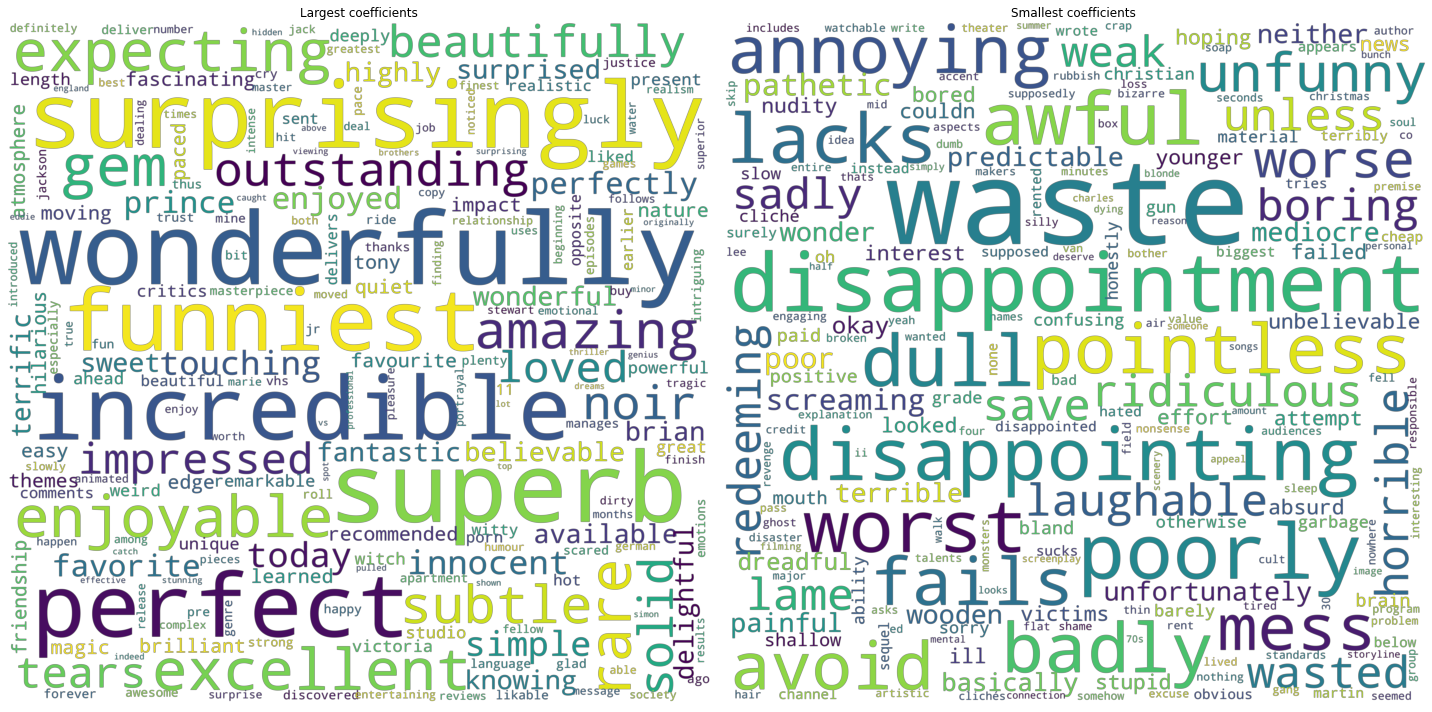

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20, 10))
ax[0].imshow(positive_wordcloud, interpolation='bilinear', aspect='auto')
ax[0].axis('off')
ax[0].set_title('Largest coefficients')
ax[1].imshow(negative_wordcloud, interpolation='bilinear', aspect='auto')
ax[1].axis('off')
ax[1].set_title('Smallest coefficients')

plt.tight_layout()


### How performance depends on size of train data? Learning curve.

Let's explore how train, val performance changes depending on how much data the model uses for training.

Your task is to train the model on train subsets of different sizes (randomly pick `n` reviews from train), calculate train and val accuracies in each case and plot the results (with train size on x axis, accuracy on y axis) -- there will be two curves, for train and for val. This plot is called Learning curve.

In [ ]:
train_sizes = np.arange(1000, len(y_train), 1000)
scores_train = []
scores_val = []

for train_size in train_sizes:
    """
    TODO: YOUR CODE GOES HERE
    """
    inds = np.random.randint(len(y_train), size=train_size)
    X_train_sub = X_train[inds,:]
    y_train_sub = y_train[inds]
    model = LogisticRegression()
    model.fit(X_train_sub , y_train_sub)
    y_train_pred = model.predict(X_train_sub)
    y_val_pred = model.predict(X_val)
    scores_train.append(accuracy_score(y_train_sub, y_train_pred))
    scores_val.append(accuracy_score(y_val, y_val_pred))
    

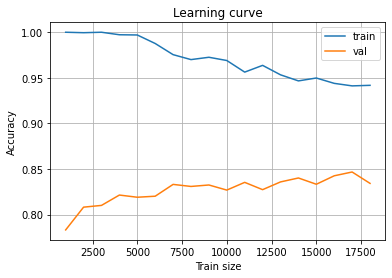

In [ ]:
plt.plot(train_sizes, scores_train, label="train")
plt.plot(train_sizes, scores_val, label="val")
plt.title("Learning curve")
plt.xlabel("Train size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# Hyperparameter Tuning & Model Selection
There are hyperparameters -- the model configuration whose value is set before learning process -- associated with each model design. 
For example, in `vectorizer = CountVectorizer(max_features=2000)`, `max_features=2000` is a hyperparameter.

We train the models with different hyperparameters and select the model that has the best validation performance as the best model. And, we report the performance of that best model on the test data as our final test score. 
(You should **never** use test data for hyperparameter tuning and model selection).

Now, try tuning the hyperparameters of the model using validation set and report the test accuracy of the best model!


### How performance depends on the number of features?  
Similar to the previous section, explore how val performance changes depending on different sizes of `max_features`.

In [ ]:
max_feature_sizes = np.arange(100, 4000, 500)
scores_train = []
scores_val = []

for max_feature in max_feature_sizes:
    print(max_feature)
    """
    TODO: YOUR CODE GOES HERE
    """
    vectorizer = CountVectorizer(max_features=max_feature)
    vectorizer.fit(train_contents)
    X_train = vectorizer.transform(train_contents)
    X_val = vectorizer.transform(val_contents)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    scores_train.append(accuracy_score(y_train, y_train_pred))
    scores_val.append(accuracy_score(y_val, y_val_pred))
    

100
600


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


1100


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


1600


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


2100


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


2600


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


3100


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


3600


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


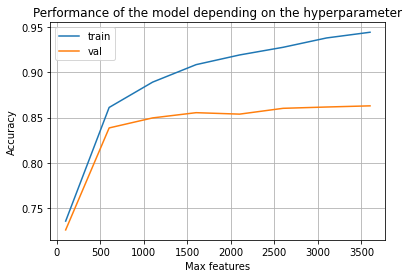

In [ ]:
plt.plot(max_feature_sizes, scores_train, label="train")
plt.plot(max_feature_sizes, scores_val, label="val")
plt.title("Performance of the model depending on the hyperparameter")
plt.xlabel("Max features")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()